____


**project**: `pneumonia prediction`

**date**: `2022-04-24`

**decription:** `given an image of a chest-x-ray we are going to predict if the person have pneumonia or not if he/she has pneumonia is it a pneumonia bacteria or a pneumonia virus.`

**main:** ``computer vision(cv) pytorch``

**programmer:** `crispen gari`

**architecture:** `LeNet`

**language**: `python`

____


### Pneumonia

There are two types of Pneumonia: 

1. Bacteria Pneumonia
2. Viral Pneumonia


<p align="center"><img src="https://www.news-medical.net/image.axd?picture=2021%2F8%2Fshutterstock_1455103604.jpg" width="100%"/></p>


Using Artificial Intelligence we want to create a simple model that will be able to detect weather a person has `Pneumonia-Bacteria`, `Pneumonia-virus`  or `Normal` given their `chest-x-ray` image.

### Model Achitecture

For the model achitecture we are going to use the `LeNet` which was discussed in [this paper](http://yann.lecun.com/exdb/lenet/). The following image shows how the model achitecture looks like.


<p align="center"><img src="https://camo.githubusercontent.com/3e8be2bfcb8f7dd1006e54d2b294fcb3123022ce28d32dfe8e0fb5a1bda1f480/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f626c6f622f6d61737465722f6173736574732f6c656e6574352e706e673f7261773d31" width="100%"/></p>





### Chest X-Ray Images (Pneumonia)

In this notebook we are going to train a deep learning model using the backpropagation algorithim with the `LeNet` model achitecture that will detect wether `Pneumonia` infection on images.

This will be a simple basic categorical classification on images using python pytorch and torchvision.


### Dataset

The dataset that i will be using was found on [kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).


The images are uploaded on my google drive so that i can easily load them in my google colab notebook.


### Folder structure:

The images are arranged in the following format in my google drive:

```
📁 chest-exray
    📁  train
      📁  PNEUMONIA_BACTERIA
          ...
      📁  PNEUMONIA_VIRAL
          ...
      📁  NORMAL
          ...
    📁  test'
      📁  PNEUMONIA_BACTERIA
          ...
      📁  PNEUMONIA_VIRAL
          ...
      📁  NORMAL
          ...
    📁  val
      📁  PNEUMONIA_BACTERIA
          ...
      📁  PNEUMONIA_VIRAL
          ...
      📁  NORMAL
          ...

key: ... (images)
```


### Mounting the drive

In the following code cell we are going to mount the google drive which is where our image dataset are located.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Installing Helper Packages

In the following code cell we are going to install the package called `helperfns` that i've created and provide us with some usefull helper functions for machine learning.

In [2]:
pip install helperfns -q

  Preparing metadata (setup.py) ... done


### Basic imports

In the following code cell we are going to import the basic packages that we will be using in this notebook.

In [3]:
import torch
import random
import os
import copy
import shutil
import time

import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt

from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix
from helperfns.torch import models
from helperfns.utils import hms_string

torch.__version__

'2.0.1+cu118'

### Seeds

In the following code cell we are going to set-up the `SEED` for reproducivity in this notebook.


In [4]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device

In the following code cell we are going to get the `gpu` as our device if possible for training speed.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Base path to where the images are

The base path where our images sets are is declared in the following code cell: 

In [6]:
base_path = "/content/drive/My Drive/Computer Vision/chest-exray"
os.listdir(base_path)

['train', 'test', 'val']

### Image transformations

We are going to load the images using the `datasets.ImageFolder` from `torchvision` so we need to define some transformation on our images for each set. The following transforms are going to be applied to our images in sequence using the `transforms.Compose`

1. train
  * Resize (32, 32)
  * RandomRotation()
  * RandomHorizontalFlip()
  * RandomCrop(32)
  * ToTensor()
  * Grayscale()
  * Normalize() with meand and std = `.5`

2, 3. test/validation
  * Resize (32, 32)
  * ToTensor()
  * Grayscale()
  * Normalize() with meand and std = `.5`




In [7]:
mean = std = .5

In [8]:
image_transforms = {
    "train": transforms.Compose([
       transforms.Resize([32,32]),
       transforms.RandomRotation(5),
       transforms.RandomHorizontalFlip(.5),
       transforms.RandomCrop(32, padding=2),
       transforms.ToTensor(),
       transforms.Grayscale(
         num_output_channels =1
       ),
       transforms.Normalize(mean=[mean], std=[std], inplace=False)                         
    ]),
    "val": transforms.Compose([
        transforms.Resize([32,32]),
        transforms.ToTensor(),
        transforms.Grayscale(
         num_output_channels =1
       ),
        transforms.Normalize(mean=[mean], std=[std], inplace=False)
    ]),
    "test": transforms.Compose([
        transforms.Resize([32,32]),
        transforms.ToTensor(),
        transforms.Grayscale(
         num_output_channels =1
       ),
        transforms.Normalize(mean=[mean], std=[std], inplace=False)
    ])
}

### Creating a dataset

We are then going to create a `image_dataset` wich will contain all the our three sets `train`, `test` and `val`.

In [9]:
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(base_path, x),
        transform = image_transforms[x]
    ) for x in os.listdir(base_path)
}

### Class names

In the following code cell we are going to get our class names that we will store in the `class_names` variable which are:

1. NORMAL
2. PNEUMONIA_BACTERIA
3. PNEUMONIA_VIRAL

In [10]:
class_names = image_datasets["train"].classes
class_names

['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRAL']

### Splitted Sets

Next we are going to get the data for each set from the giant `image_dataset`.

In [11]:
train_data = image_datasets["train"]
val_data = image_datasets["val"]
test_data = image_datasets["test"]

### Checking Examples
In the following code cell we are ging to count how many example do we have in our dataset.

In [12]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = [("training", len(train_data)), 
             ("testing", len(test_data)),
             ('validation', len(val_data)),
             ("total", f"{ len(test_data) + len(train_data) + len(val_data):,}")
        ]

tabulate_data(columns, data_rows, title)


+------------+-------+
| SET        | TOTAL |
+------------+-------+
| training   |  5442 |
| testing    |  1135 |
| validation |  1135 |
| total      | 7,712 |
+------------+-------+


### Class names to index

> Note that we can check the `class` to `index` mapping from our train data as a dictionary. This will help us to identify the classname (string) with the class label(integer) for all the classes.

In [13]:
train_data.class_to_idx

{'NORMAL': 0, 'PNEUMONIA_BACTERIA': 1, 'PNEUMONIA_VIRAL': 2}

### visualizing images

In the next code cell we are going to create a simple helper function that will allow us to visualize images called `plot-images`

In [14]:
def plot_images(images, labels, cols=5):
  rows = 4
  fig = plt.figure()
  fig.set_size_inches(cols * 2, rows * 2)
  for i, (image, label) in enumerate(zip(images, labels)):
      plt.subplot(rows, cols, i + 1)
      plt.axis('off')
      plt.imshow(image.view(32, 32), cmap="gray")
      plt.title(class_names[label], color ='k', fontsize=16 )

Now we can get the imahes and labels from the train data so that we can visualize them.

In [15]:
images = [image for image, label in [train_data[i] for i in range(32)] ]
labels = [label for image, label in [train_data[i] for i in range(32)] ]


Now we can use our `plot_images` function to visualize the images.

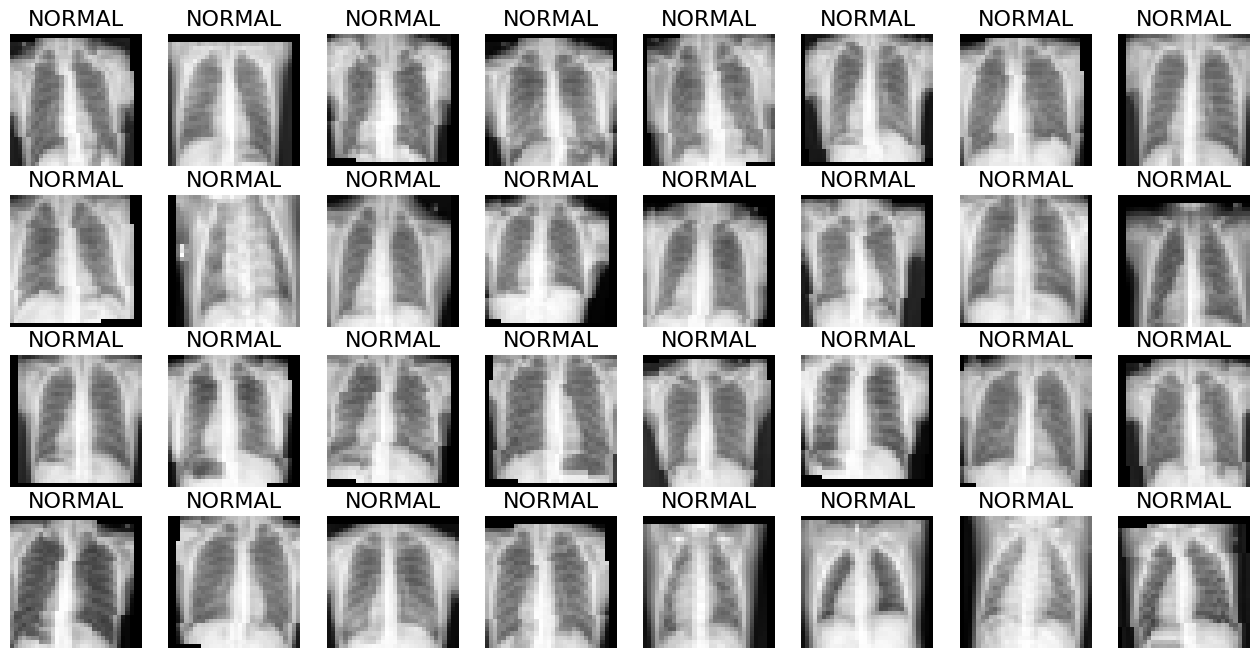

In [16]:
plot_images(images, labels, cols=8)

### Creating iterators

We are going to create iterators for all our 3 datasets with a batch size of `64`

In [17]:
BATCH_SIZE = 64
train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE
                                 )
valid_iterator = data.DataLoader(val_data,
                                 shuffle=False,
                                 batch_size=BATCH_SIZE
                                 )
test_iterator = data.DataLoader(test_data,
                                 shuffle=False,
                                 batch_size=BATCH_SIZE
                                 )

### Defining the LeNet Model

Our implementation of `LeNet` model will not be the same as the actual one. We are going to use because in the actual implementation they used images which were `32x32` ofwhich we are using images with size `28x28` and also we are not going to use `Gaussian connections`

In [18]:
class LeNet(nn.Module):
  def __init__(self, output_dim):
    super(LeNet, self).__init__()
    self.maxpool2d = nn.MaxPool2d(2)
    self.relu = nn.ReLU()
    self.convs = nn.Sequential(
        nn.Conv2d(
          in_channels=1,
          out_channels=6,
          kernel_size =5
        ),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size = 5
        ),
        nn.MaxPool2d(2),
        nn.ReLU()
    )
    self.classifier = nn.Sequential(
        nn.Linear(16 * 5 * 5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, output_dim)
    )
  def forward(self, x):
    # x = [batch size, 1, 32, 32]
    x = self.convs(x)
    # x = [batch_size, 16, 5, 5]
    x = x.view(x.shape[0], -1) # x = [batch size, 16*5*5]
    x = self.classifier(x)
    return x

### Model Instance

I'm the following code cell we are going to create an instance of our model and name it `pneumonia_lenet`.

In [19]:
OUTPUT_DIM = len(class_names)
pneunomia_lenet = LeNet(OUTPUT_DIM).to(device)
pneunomia_lenet

LeNet(
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (convs): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=3, bias=True)
  )
)

### Counting the model parameters

In the following code cell we are then going to count the model parameters for our `pneunomia_lenet` model.

In [20]:
models.model_params(pneunomia_lenet)

TOTAL MODEL PARAMETERS: 	61,111
TOTAL TRAINABLE PARAMETERS: 	61,111


Our model has `~61K` total parameters.

### Optimizer

For the optimizer we are going to use `Adam` with default parameters.

In [21]:
optimizer = torch.optim.Adam(pneunomia_lenet .parameters())

### Criterion
For the criterion/loss function we are going to use the `CrossEntropyLoss` since it is a multi-class classification.

In [22]:
criterion = nn.CrossEntropyLoss().to(device)

### Categorical accuracy function

This function will calculate a accuracy for the predicted labels aganist the actual labels.

In [23]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  return correct.float()/y.shape[0]

### Training and Evaluation functions

In the following code cell we are going to create a `train` and `eval` function.

In [24]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    y_pred = model(x)
    # Calculate the loss and accuracy
    y_pred = y_pred.squeeze()

    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss +=loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)
      y_pred = y_pred.squeeze()
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

### Training loop 

We are then going to run our training loop as save the model when the previous validation loss is less that the current validation loss. We are only going to train the model for `20` epochs.

In [25]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

In [26]:
EPOCHS = 20
best_valid_loss = float('inf')
MODEL_NAME = "pneunomia_lenet.pt"
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
last_saved_epoch = 1
history = History()
training_start = time.time()
for epoch in range(EPOCHS):
  start = time.time()

  train_loss, train_acc = train(pneunomia_lenet, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(pneunomia_lenet, valid_iterator, criterion, device)

  save_status = "(not saving)"
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    save_status = "(saving)"
    last_saved_epoch = epoch + 1
    torch.save(pneunomia_lenet.state_dict(), MODEL_NAME)
  end = time.time()
  history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
  data_rows = [
      ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
  ]
  
  title = f"EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
  print(title)
  tabulate_data(column_names, data_rows, title)
  
training_end = time.time()

EPOCH 01/20: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.880 |   58.43% | 0:17:32.43 |
| Validation | 0.800 |   60.31% |            |
+------------+-------+----------+------------+
EPOCH 02/20: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.723 |   67.71% | 0:02:03.20 |
| Validation | 0.765 |   64.44% |            |
+------------+-------+----------+------------+
EPOCH 03/20: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.663 |   70.62% | 0:02:00.26 |
| Validation | 0.715 |   71.18% |            |
+------------+-------+----------+------------+
EPOCH 04/20: (saving)
+------------+-------+----------+------------+
| Set        |  Los

### Visualizing the training History

In this section of the notebook we are going to visualize the training history of the model over `N` epochs.

In [27]:
print("----- TOTAL TRAINING TIME ")
rows = [
      ["TOTAL EPOCHS", f'{EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(training_end-training_start)}']
]
tabulate_data(['', 'value'], rows, "TOTAL TRAINING TIME")

----- TOTAL TRAINING TIME 
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         20 |
| LAST SAVED EPOCH    |         20 |
| TOTAL TRAINING TIME | 0:55:03.84 |
+---------------------+------------+


Let's plot how long the model took to train each epoch from our `history` object.

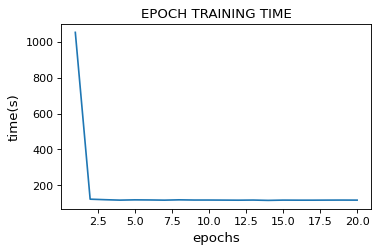

In [28]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time)
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)
plt.show()

Let's plot the model's training history in terms of `acuracy` and `losses` over `n` epochs in our `train` and `valid` sets.

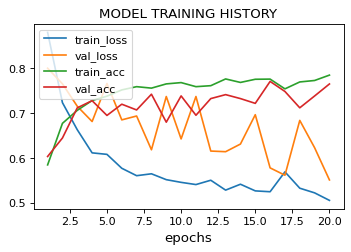

In [29]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, label="train_loss")
plt.plot(epochs, history.val_losses, label="val_loss")
plt.plot(epochs, history.train_acc, label="train_acc")
plt.plot(epochs, history.val_acc, label="val_acc")
plt.title("MODEL TRAINING HISTORY", color="k", fontsize=12)
plt.legend()
plt.xlabel("epochs", fontsize=12)
plt.show()

Next we are going to evaluate the best model and check for the model `loss` and `accuracy` based on the unseen dataset which is the `test`.

In [30]:
pneunomia_lenet.load_state_dict(torch.load(MODEL_NAME))

test_loss, test_acc = evaluate(pneunomia_lenet, test_iterator, criterion, device)
title = "Model Evaluation Summary"
print(title)
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_data(column_names, data_rows, title)


Model Evaluation Summary
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.551 |   76.51% |            |
+------+-------+----------+------------+


### Downloading the best model

We are going to download the saved model as a file in the following code cell.

In [31]:
from google.colab import files
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model inference

For model inference we are going to take in an image and make predictions on it.


### Image preprocessing

For image preprocessing we are going to use `torchvision` transforms so that we tranform our image in the way we want it.

1. Given an image resize it to `32x32`
2. Convert the image to tensor 
3. convert the image to grayscale

> _Note that during image processing we should use `.5` as our ``mean`` and `std` since we used this during our train transforms._




In [32]:
from PIL import Image

In [33]:
def preprocess_img(img):
  """
  takes in a pillow image and pre process it
  """
  preproces_1 =  nn.Sequential(
   transforms.Resize([32,32]),
   transforms.Grayscale(1)
  )
  preprocess_2 =  nn.Sequential(
    transforms.Normalize(mean=[mean], std=[std], inplace=False)
  )
  img = preprocess_2(transforms.ToTensor()(preproces_1(img)))
  return img

In [34]:
img_path = os.path.join(base_path, "train/PNEUMONIA_BACTERIA/person1_bacteria_1.jpeg")
pil_img = Image.open(img_path)
img = preprocess_img(pil_img)

### Predict method

The predict method will take in the following args: 

1. model
2. image (processed image)
3. device (cuda or cpu)

In [35]:
def predict(model, image, device):
  image = torch.unsqueeze(image, 0).to(device)
  preds = model(image)
  preds = F.softmax(preds, dim=1).detach().cpu().numpy().squeeze()

  predicted_label = np.argmax(preds)

  all_preds = [
      {
      'label': i,
      'class_label': class_names[i],
      'probability': np.round(preds[i], 2),
      } for i, _ in enumerate(preds)
  ]

  res ={
      'label': predicted_label,
      'class_label': class_names[predicted_label],
      'probability': np.round(preds[predicted_label], 2),
      'predictions': all_preds
  }
  return res

predict(pneunomia_lenet, img, device)

{'label': 1,
 'class_label': 'PNEUMONIA_BACTERIA',
 'probability': 0.5,
 'predictions': [{'label': 0, 'class_label': 'NORMAL', 'probability': 0.0},
  {'label': 1, 'class_label': 'PNEUMONIA_BACTERIA', 'probability': 0.5},
  {'label': 2, 'class_label': 'PNEUMONIA_VIRAL', 'probability': 0.5}]}

### Model Evaluation metrics

In this section we are going to evaluate the best model and visualize the matrics. We are going to use the following evaluation methods on this classification task.

1. confusion matrix
2. classification report.


First of all we need to get the actual values and predicted values from the `test_iteraror` so that we will be able to use all the examples in the `test` dataset to evaluate our model. We are going to define a function called `get_predictions` this function will take in the `model`, `iterator` and `device` as parameter and return the following lists of values:

1. images - the image to be predicted
2. labels - the actual image label
3. probs - the list of probabilities for the image to belong to a certain class.



In [36]:
def get_predictions(model, iterator, device):
  model.eval()
  images = []
  labels = []
  probs = []
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())
  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return images, labels, probs

Let's go ahead and get the `images`, `labels` and `probabilities` from the `test_iterator` using our `get_predictions` function

In [37]:
test_images, test_labels, probs = get_predictions(pneunomia_lenet, test_iterator, device)

The `probs` are not the predicted labels, it is a torch tensor of size `3` that looks as follow:

```
tensor([0.8013, 0.1063, 0.0924])
```
So these are just probabilities that are telling us that, the predicted image has `~80%` chance of belonging to class `0`, `~11%` chance of belonging to class `1` and `9%` chance of belonging to class 2. Basically the model is telling us that, I think the image you gave me belongs to class `0`. 


To get the predicted values from the images in the `test_set` we need to use the `torch.argmax()` function which returns us the index with the highest number in a `torch tesnor`. We are going to calculate the `argmax` of our probability in the `first` dimenion to get all the predicted values labels as follows:

In [38]:
pred_labels = torch.argmax(probs, 1)
pred_labels

tensor([0, 0, 0,  ..., 2, 1, 2])

### Ploting predictions

Now that we have our `predicted` labels and `real` labels from the `test` dataset. We can use them to visualize how good the model is performing during inference. Let's define a function called `plot_predictions_images` which plots the predicted images together with their labels.

In [39]:
images = test_images
labels = test_labels.numpy()
preds = pred_labels.numpy()

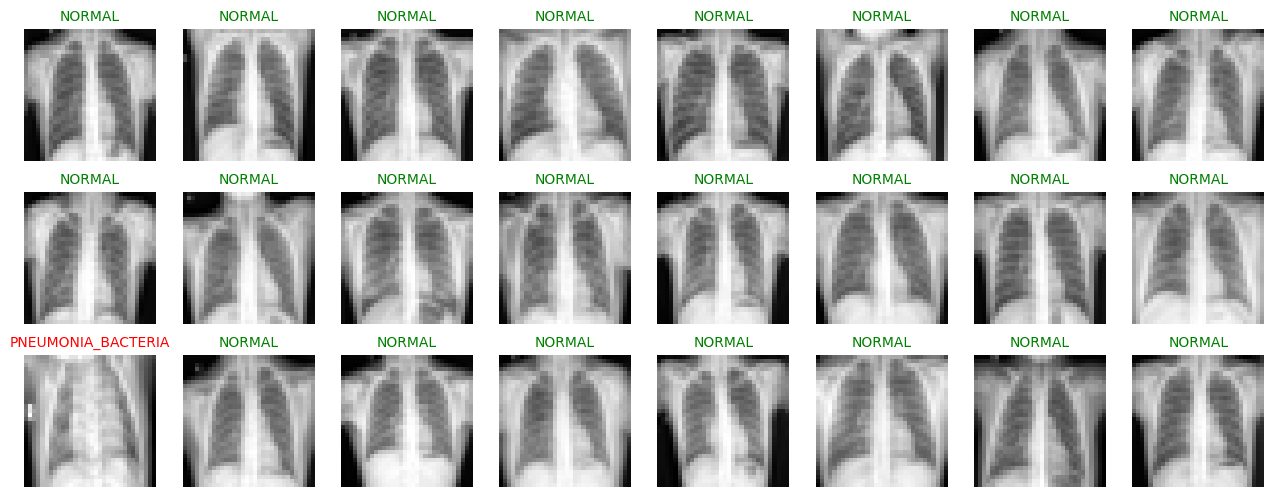

In [40]:
def plot_predictions_images(images_and_classes, 
                            labels_true, labels_pred, 
                            cols=5):
    rows = 3
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image, label_true, label_pred) in enumerate(zip(images_and_classes, labels_true.astype("int32"), labels_pred)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image.view(32, 32), cmap="gray")
        plt.title(class_names[label_pred], color ='g' if label_true == label_pred else 'r', fontsize=10 )

plot_predictions_images(images[:24], labels[:24], preds[:24], cols=8)


From the above visualization the images that has a `red` title are mis-predicted by the model.

#### The confusion matrix

Let's create a confusion matrix as a way of visualizing how good our model is when it comes to predicting images in the `test` dataset. We are going to use a function called `plot_complicated_confusion_matrix` from `helperfns.visualization` in the following code cell, this function will take in the real-labels, predicted labels together with the classes (textual labels e.g, normal)

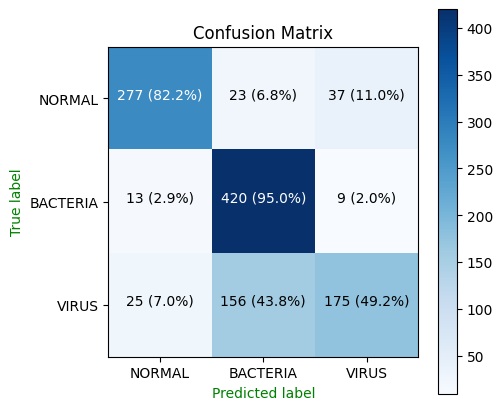

In [41]:
plot_complicated_confusion_matrix(labels, preds, ['NORMAL', 'BACTERIA', 'VIRUS'], fontsize=10, figsize=(5, 5), )

### Classification report

In the following code cell we are going to print the classification report as a way of measuring how good our model was in predicting (normal, pneumonia-virus and pneumonia-bacteria).

In [42]:
from sklearn.metrics import classification_report

In [43]:
cr = classification_report(labels, preds, output_dict=False)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       337
           1       0.70      0.95      0.81       442
           2       0.79      0.49      0.61       356

    accuracy                           0.77      1135
   macro avg       0.79      0.75      0.75      1135
weighted avg       0.78      0.77      0.76      1135

